In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np
import pickle
import cv2
import seaborn as sn
import pandas as pd 
import tensorflow as tf
import matplotlib.pyplot as plt
import os, random, time
import matplotlib.image as mpimg

from tensorflow import keras
from keras.preprocessing import image
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras.layers import Flatten, Dense
from keras.layers import BatchNormalization
from os import listdir
from keras.models import Model
from keras import backend as K
from keras.layers import Input
from keras.optimizers import Adam
from keras.callbacks import LearningRateScheduler,ReduceLROnPlateau
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing import image
from keras.preprocessing.image import img_to_array
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report 
from sklearn.datasets import make_classification
from sklearn.preprocessing import label_binarize
from scipy import interp
from itertools import cycle
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score
from tensorflow.keras.applications.resnet import preprocess_input as preprocess_resnet
from tensorflow.keras.applications.xception import preprocess_input as preprocess_xception
from tensorflow.keras.applications.inception_resnet_v2 import preprocess_input as preprocess_inceptionv3
from sklearn.preprocessing import OneHotEncoder
from tensorflow.keras.callbacks import EarlyStopping

In [ ]:
EPOCHS = 100
BS = 32
directory_root = "/content/drive/MyDrive/datasets/covid19/"
width=299
height=299
depth=3

In [ ]:
def get_paths_and_labels(dataset_path):
    """Returns paths and labels of images in the `dataset_path`

    If the argument `extension` isn't passed in, the default '.jpg' is used.

    Parameters
    ----------
    dataset_path : str
        The path to the dataset
    extension : str, optional
        The extension of the file, this can be with or without the dot `.` (default is '.jpg')
    """

    
    paths = []
    labels = []
    for root, dirs, files in os.walk(dataset_path):
        if not dirs:
            path = '/'.join(root.split(os.sep))
            for file in files:
                if file.endswith(".jpg")== True or file.endswith(".png")== True or file.endswith(".jpeg")  :
                    if os.path.getsize(path+'/'+file) > 0:
                        labels += path.split('/')[-1:]
                        paths += [path+'/'+file]
                    else:
                        print(f'{path+"/"+file} is corrupt or empty')
    return paths, labels

In [ ]:
path, label = get_paths_and_labels(directory_root)

In [ ]:
df = pd.DataFrame([path, label]).T

In [ ]:
print(df)

                                                      0       1
0     /content/drive/MyDrive/datasets/covid19/covid/...   covid
1     /content/drive/MyDrive/datasets/covid19/covid/...   covid
2     /content/drive/MyDrive/datasets/covid19/covid/...   covid
3     /content/drive/MyDrive/datasets/covid19/covid/...   covid
4     /content/drive/MyDrive/datasets/covid19/covid/...   covid
...                                                 ...     ...
6181  /content/drive/MyDrive/datasets/covid19/normal...  normal
6182  /content/drive/MyDrive/datasets/covid19/normal...  normal
6183  /content/drive/MyDrive/datasets/covid19/normal...  normal
6184  /content/drive/MyDrive/datasets/covid19/normal...  normal
6185  /content/drive/MyDrive/datasets/covid19/normal...  normal

[6186 rows x 2 columns]


In [ ]:
df_train, df_test = train_test_split(df, test_size = 0.2, stratify = df[1])

In [ ]:
test_gen = ImageDataGenerator(
            validation_split = 0,
            preprocessing_function = preprocess_xception,
            )

train_gen = ImageDataGenerator(
            validation_split = 0,
            preprocessing_function = preprocess_xception,
            rotation_range=30, 
            width_shift_range=0.2,
            height_shift_range=0.2, 
            shear_range=0.15, 
            zoom_range=0.15,
            horizontal_flip=True, 
            fill_mode="nearest"
            )

train = train_gen.flow_from_dataframe(df_train, x_col=0, y_col=1, target_size=(width, height), seed = 10, shuffle=False)
test = test_gen.flow_from_dataframe(df_test, x_col=0, y_col=1, target_size=(width, height), seed= 10, shuffle=False)

Found 4948 validated image filenames belonging to 2 classes.
Found 1238 validated image filenames belonging to 2 classes.


In [ ]:
img_shape = (width, height, depth)

In [ ]:
# # Inception
# InceptionV3 = tf.keras.applications.InceptionV3(weights= "imagenet", input_shape=img_shape, include_top=False)
# InceptionResNetV2 = tf.keras.applications.InceptionResNetV2(weights="imagenet", input_shape=img_shape, include_top=False)
# # Xception
Xception = tf.keras.applications.Xception(weights="imagenet", input_shape=img_shape, include_top=False)
# # VGG
# VGG16 = tf.keras.applications.VGG16(weights="imagenet", input_shape=img_shape, include_top=False)#224
# VGG19 = tf.keras.applications.VGG16(weights="imagenet", input_shape=img_shape, include_top=False)#224
# # Residual Net
# ResNet50 = tf.keras.applications.ResNet50(weights="imagenet", input_shape=img_shape, include_top=False)#224
# ResNet101 = tf.keras.applications.ResNet50(weights="imagenet", input_shape=img_shape, include_top=False)#224
# ResNet152 = tf.keras.applications.ResNet101(weights="imagenet", input_shape=img_shape, include_top=False)#224
# ResNet50V2 = tf.keras.applications.ResNet152(weights="imagenet", input_shape=img_shape, include_top=False)#224
# ResNet101V2 = tf.keras.applications.ResNet101V2(weights="imagenet", input_shape=img_shape, include_top=False)#224
# ResNet152V2 = tf.keras.applications.ResNet152V2(weights="imagenet", input_shape=img_shape, include_top=False)#224
# # MobileNet
# MobileNet = tf.keras.applications.MobileNet(weights="imagenet", input_shape=img_shape, include_top=False)#224
# MobileNetV2 = tf.keras.applications.MobileNetV2(weights="imagenet", input_shape=img_shape, include_top=False)#224
# # NasNet
# NASNetMobile = tf.keras.applications.NASNetMobile(weights="imagenet", input_shape=img_shape, include_top=False)#224
# NASNetLarge = tf.keras.applications.NASNetLarge(weights="imagenet", input_shape=img_shape, include_top=False)#224
# # DenseNet
# DenseNet121 = tf.keras.applications.DenseNet121(weights="imagenet", input_shape=img_shape, include_top=False)#224
# DenseNet169 = tf.keras.applications.DenseNet169(weights="imagenet", input_shape=img_shape, include_top=False)#224
# DenseNet201 = tf.keras.applications.DenseNet201(weights="imagenet", input_shape=img_shape, include_top=False)#224
# # EfficientNet
# EfficientNetB0 = tf.keras.applications.EfficientNetB0(weights="imagenet", input_shape = img_shape, include_top=False)
# EfficientNetB1 = tf.keras.applications.EfficientNetB1(weights="imagenet", input_shape = img_shape, include_top=False)
# EfficientNetB2 = tf.keras.applications.EfficientNetB2(weights="imagenet", input_shape = img_shape, include_top=False)
# EfficientNetB3 = tf.keras.applications.EfficientNetB3(weights="imagenet", input_shape = img_shape, include_top=False)
# EfficientNetB4 = tf.keras.applications.EfficientNetB4(weights="imagenet", input_shape = img_shape, include_top=False)
# EfficientNetB5 = tf.keras.applications.EfficientNetB5(weights="imagenet", input_shape = img_shape, include_top=False)
# EfficientNetB6 = tf.keras.applications.EfficientNetB6(weights="imagenet", input_shape = img_shape, include_top=False)
# EfficientNetB7 = tf.keras.applications.EfficientNetB7(weights="imagenet", input_shape = img_shape, include_top=False)

83689472/83683744 [==============================] - 1s 0us/step


In [ ]:
def new_toplayer(base_model):
  model = tf.keras.models.Sequential([
        base_model,
        tf.keras.layers.GlobalAveragePooling2D(),
        tf.keras.layers.Dense(256, activation="relu"),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(2, activation="softmax")
        ])
  return model

In [ ]:
baseModel = [
              Xception
              ]

In [ ]:
# baseModel = [
#               InceptionV3, 
#               InceptionResNetV2, 
#               Xception, 
#               VGG16, 
#               VGG19, 
#               ResNet50, 
#               ResNet101, 
#               ResNet152, 
#               ResNet50V2, 
#               ResNet101V2, 
#               ResNet152V2,
#               MobileNet,
#               MobileNetV2,
#               NASNetMobile,
#               NASNetLarge,
#               DenseNet121,
#               DenseNet169,
#               DenseNet201,
#               EfficientNetB0,
#               EfficientNetB1,
#               EfficientNetB2,
#               EfficientNetB3,
#               EfficientNetB4,
#               EfficientNetB5,
#               EfficientNetB6,
#               EfficientNetB7
#               ]

In [ ]:
for i in baseModel:
  i.trainable = False

In [ ]:
model=[]
for i in baseModel:
  model_temp = new_toplayer(i)
  model.append(model_temp)

In [ ]:
print(model)

In [ ]:
# model = new_toplayer(pretrained_network)

In [ ]:
for i in model:
  print(i.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
xception (Functional)        (None, 10, 10, 2048)      20861480  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 256)               524544    
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 514       
Total params: 21,386,538
Trainable params: 525,058
Non-trainable params: 20,861,480
_________________________________________________________________
None


In [ ]:
# from keras.utils.vis_utils import plot_model
# plot_model(model, to_file='model.png', show_shapes=True, show_layer_names=True)

In [ ]:
for i in model:
  i.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
                    optimizer=tf.optimizers.Adam(learning_rate=0.001),
                    metrics=['accuracy'])

In [ ]:
#Model Checkpoint Callback
!rm -rf /content/model
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath='/content/model/',
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True,
    verbose=1)

In [ ]:
early_stopping = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)
history = []
for i in model:
  history_temp = i.fit(train,
                       epochs = EPOCHS,
                       batch_size = BS,
                       validation_data = test,
                       callbacks=[checkpoint_callback,early_stopping]
                       )
  history.append(history_temp)

Epoch 1/100
155/155 [==============================] - 182s 1s/step - loss: 0.1640 - accuracy: 0.9386 - val_loss: 0.1730 - val_accuracy: 0.9321

Epoch 00001: val_accuracy improved from -inf to 0.93215, saving model to /content/model/
Epoch 2/100
155/155 [==============================] - 180s 1s/step - loss: 0.1507 - accuracy: 0.9479 - val_loss: 0.2092 - val_accuracy: 0.9168

Epoch 00002: val_accuracy did not improve from 0.93215
Epoch 3/100
155/155 [==============================] - 179s 1s/step - loss: 0.1373 - accuracy: 0.9509 - val_loss: 0.1335 - val_accuracy: 0.9491

Epoch 00003: val_accuracy improved from 0.93215 to 0.94911, saving model to /content/model/
Epoch 4/100
155/155 [==============================] - 179s 1s/step - loss: 0.1343 - accuracy: 0.9535 - val_loss: 0.1772 - val_accuracy: 0.9313

Epoch 00004: val_accuracy did not improve from 0.94911
Epoch 5/100
155/155 [==============================] - 179s 1s/step - loss: 0.1401 - accuracy: 0.9493 - val_loss: 0.1224 - val_ac

In [ ]:
for i in model:
  scores = i.evaluate(test)
  print(f"Test Accuracy: {scores[1]*100}")

39/39 [==============================] - 21s 529ms/step - loss: 0.1494 - accuracy: 0.9467
Test Accuracy: 94.66882348060608


In [ ]:
baseModel_name = [
                  "Xception"
                  
]

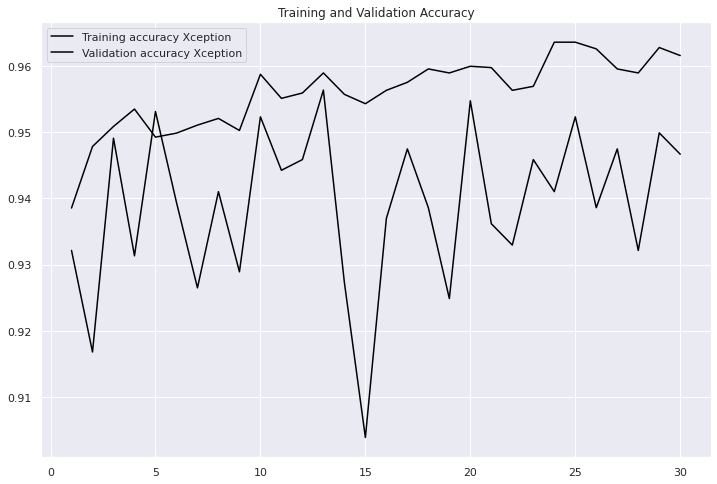

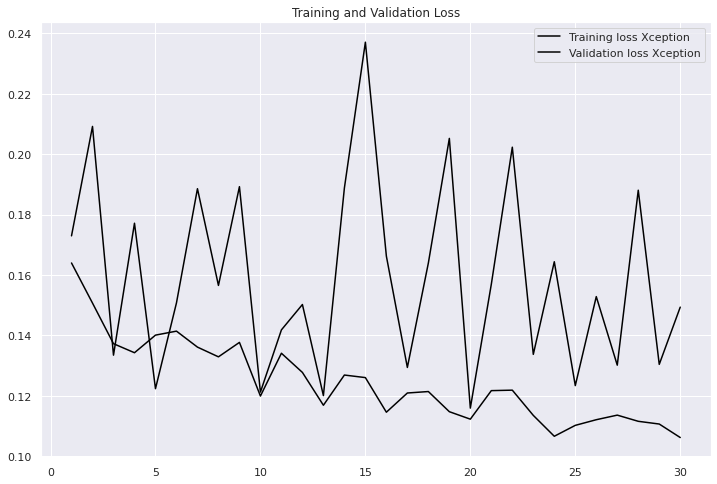

In [ ]:
color_acc = ["black", "gold"]
color_loss = ["black", "gold"]


#Train dan validation accuracy
j = 0
fig, ax = plt.subplots(figsize=(12,8))
for i in history:
  acc = i.history['accuracy']
  val_acc = i.history['val_accuracy']
  epochs = range(1, len(acc) + 1)

  ax.plot(epochs, acc, color_acc[j], label= f"Training accuracy {baseModel_name[j]}")
  ax.plot(epochs, val_acc, color_acc[j], label= f'Validation accuracy {baseModel_name[j]}')
  plt.title('Training and Validation Accuracy')
  plt.legend()
  j = j+1

#Train and validation loss
k = 0
fig, ax1 = plt.subplots(figsize=(12,8))
for i in history:
  loss = i.history['loss']
  val_loss = i.history['val_loss']
  epochs = range(1, len(acc) + 1)
  
  ax1.plot(epochs, loss, color_loss[k], label=f'Training loss {baseModel_name[k]}')
  ax1.plot(epochs, val_loss, color_loss[k], label=f'Validation loss {baseModel_name[k]}')
  plt.title('Training and Validation Loss')
  plt.legend()
  k = k+1
  

plt.show()


In [ ]:
model_pred = []
model_predicted = []
for i in model:
  model_pred_temp = i.predict(test, BS, verbose=2)
  model_predicted_temp = np.argmax(model_pred_temp, axis = 1)

  model_pred.append(model_pred_temp)
  model_predicted.append(model_predicted_temp)
  


39/39 - 18s


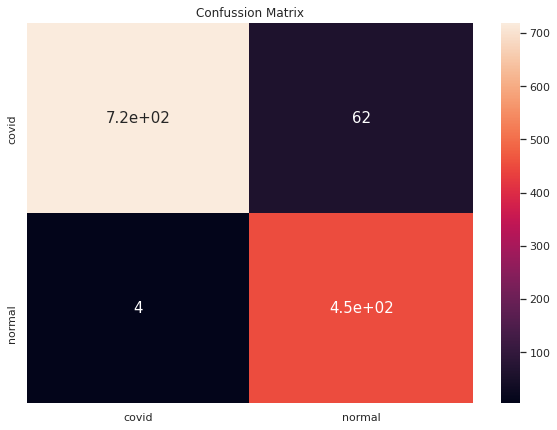

In [ ]:
labels = os.listdir(directory_root)
for i in model_predicted:
  #Membuat Confussion Matrix
  model_cm = confusion_matrix(test.classes, i) 

  #Visualisasi Confussion Matrix
  model_df_cm = pd.DataFrame(model_cm, labels, labels) 
  plt.figure(figsize = (10,7))
  plt.title('Confussion Matrix') 
  sn.set(font_scale=1) #for label size 
  sn.heatmap(model_df_cm, annot=True, annot_kws={"size": 15}) # font size 
  plt.show()

In [ ]:
for i in model_predicted:
  model_report = classification_report(test.classes, i, target_names=labels )
  print(model_report)

              precision    recall  f1-score   support

       covid       0.99      0.92      0.96       781
      normal       0.88      0.99      0.93       457

    accuracy                           0.95      1238
   macro avg       0.94      0.96      0.94      1238
weighted avg       0.95      0.95      0.95      1238



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:29: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


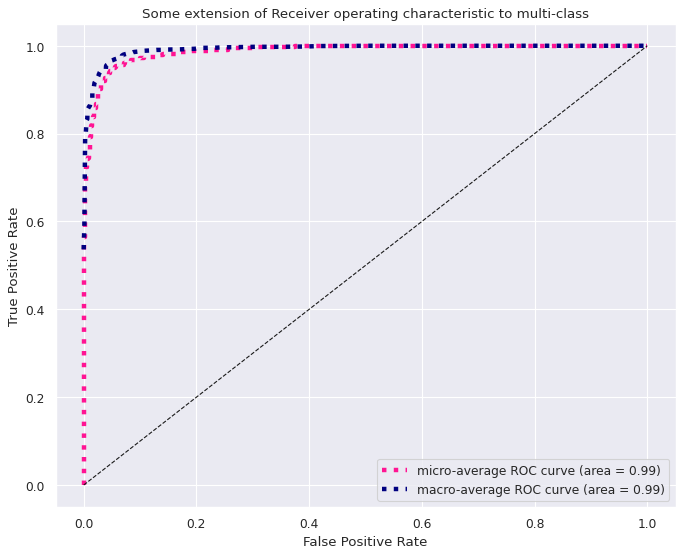

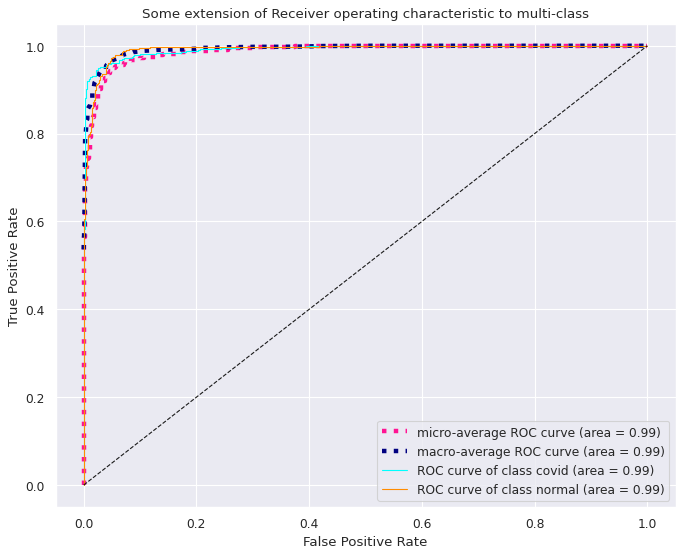

In [ ]:
n_classes = 2
for i in range(1):
  # Plot linewidth.
  lw = 1

  # Compute ROC curve and ROC area for each class
  fpr = dict()
  tpr = dict()
  roc_auc = dict()
  temporary = model_pred[i]
  y_test = OneHotEncoder().fit_transform(np.array(test.classes).reshape(-1,1)).toarray()

  for i in range(2):
      fpr[i], tpr[i], _ = roc_curve(y_test[:,i], temporary[:,i])
      roc_auc[i] = auc(fpr[i], tpr[i])

  # Compute micro-average ROC curve and ROC area
  fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), temporary.ravel())
  roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

  # Compute macro-average ROC curve and ROC area

  # First aggregate all false positive rates
  all_fpr = np.unique(np.concatenate([fpr[i] for i in range(2)]))

  # Then interpolate all ROC curves at this points
  mean_tpr = np.zeros_like(all_fpr)
  for i in range(n_classes):
      mean_tpr += interp(all_fpr, fpr[i], tpr[i])

  # Finally average it and compute AUC
  mean_tpr /= n_classes

  fpr["macro"] = all_fpr
  tpr["macro"] = mean_tpr
  roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

  # Plot all ROC curves
  plt.figure(num=None, figsize=(10, 8), dpi=80, facecolor='w', edgecolor='k')
  plt.plot(fpr["micro"], tpr["micro"],
          label='micro-average ROC curve (area = {0:0.2f})'
                ''.format(roc_auc["micro"]),
          color='deeppink', linestyle=':', linewidth=4)

  plt.plot(fpr["macro"], tpr["macro"],
          label='macro-average ROC curve (area = {0:0.2f})'
                ''.format(roc_auc["macro"]),
          color='navy', linestyle=':', linewidth=4)

  colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
  for i, color in zip(range(n_classes-97), colors):
      plt.plot(fpr[i], tpr[i], color=color, lw=lw,
              label='ROC curve of class {0} (area = {1:0.2f})'
              ''.format(i, roc_auc[i]))

  plt.plot([0, 1], [0, 1], 'k--', lw=lw)
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.title('Some extension of Receiver operating characteristic to multi-class')
  plt.legend(loc="lower right")
  plt.show()


  # Zoom in view of the upper left corner.
  plt.figure(num=None, figsize=(10, 8), dpi=80, facecolor='w', edgecolor='k')
  plt.plot(fpr["micro"], tpr["micro"],
          label='micro-average ROC curve (area = {0:0.2f})'
                ''.format(roc_auc["micro"]),
          color='deeppink', linestyle=':', linewidth=4)

  plt.plot(fpr["macro"], tpr["macro"],
          label='macro-average ROC curve (area = {0:0.2f})'
                ''.format(roc_auc["macro"]),
          color='navy', linestyle=':', linewidth=4)

  colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'grey', 'darkred', 'forestgreen'])
  i=0
  for x, color in zip(labels, colors):
      plt.plot(fpr[i], tpr[i], color=color, lw=lw,
              label='ROC curve of class {0} (area = {1:0.2f})'
              ''.format(x, roc_auc[i]))
      i=i+1

  plt.plot([0, 1], [0, 1], 'k--', lw=lw)
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.title('Some extension of Receiver operating characteristic to multi-class')
  plt.legend(loc="lower right")
  plt.show()